In [ ]:
!pip install langdetect
!pip install geopandas

     |████████████████████████████████| 983kB 13.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=1f985143667c702a009197ae64119e10f26a44d46bb26495186794a3aac62c46
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 972kB 15.6MB/s 
     |████████████████████████████████| 6.5MB 52.1MB/s 
     |████████████████████████████████| 14.8MB 208kB/s 


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import re

plt.style.use('fivethirtyeight')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from langdetect import detect

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser

import seaborn as sns

import shapely
from shapely.geometry import Point
import geopandas as gpd

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [ ]:
REVIEWS_URL = 'https://ids-storage-football-prediction.s3-eu-west-1.amazonaws.com/data_mmwd/reviews.csv'
REVIEWS_AND_POLARITY_URL = 'https://ids-storage-football-prediction.s3-eu-west-1.amazonaws.com/data_mmwd/reviews_en_polarity.csv'
CALENDAR_URL = 'https://ids-storage-football-prediction.s3-eu-west-1.amazonaws.com/data_mmwd/calendar.csv'
LISTINGS_URL = 'https://ids-storage-football-prediction.s3-eu-west-1.amazonaws.com/data_mmwd/listings.csv'

**Wczytywanie danych**

In [ ]:
df = pd.read_csv(LISTINGS_URL)

In [ ]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,34220,https://www.airbnb.com/rooms/34220,20201021220716,2020-10-23,Room available,<b>The space</b><br />This room is part of a t...,NaN,https://a0.muscache.com/pictures/192935/3bf5a8...,147438,https://www.airbnb.com/users/show/147438,Mark,2010-06-18,CA,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,NaN,1,1,[],f,f,NaN,Capital,NaN,45.40924,-75.67900,Private room in apartment,Private room,2,NaN,1 bath,1.0,1.0,"[""Wifi"", ""Heating"", ""Free parking on premises""...",$202.00,7,31,7,7,31,31,7.0,31.0,NaN,t,1,1,1,1,2020-10-23,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
1,36642,https://www.airbnb.com/rooms/36642,20201021220716,2020-10-22,City Conveniences A Country Setting,<b>The space</b><br />Are you planning a vacat...,NaN,https://a0.muscache.com/pictures/7542487/52136...,157787,https://www.airbnb.com/users/show/157787,Donna,2010-07-04,"Ottawa, Ontario, Canada",I am originally from Nova Scotia but I have li...,NaN,NaN,100%,f,https://a0.muscache.com/im/users/157787/profil...,https://a0.muscache.com/im/users/157787/profil...,NaN,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,NaN,Kitchissippi,NaN,45.40159,-75.74679,Private room in house,Private room,2,NaN,2 baths,1.0,1.0,"[""Essentials"", ""Hot water"", ""Dryer"", ""Extra pi...",$65.00,3,14,3,3,14,14,3.0,14.0,NaN,t,29,59,89,364,2020-10-22,87,1,0,2010-07-11,2020-02-17,94.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,0,1,0,0.69
2,59258,https://www.airbnb.com/rooms/59258,20201021220716,2020-10-22,Lower level of my house to rent,"Lower 1/2 of bungalow, a separate entrance, 10...",NaN,https://a0.muscache.com/pictures/359337/5d90d6...,284351,https://www.airbnb.com/users/show/284351,Elena,2010-11-11,"Ottawa, Ontario, Canada",Canada rocks!,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/284351/profil...,https://a0.muscache.com/im/users/284351/profil...,NaN,1,1,"['email', 'phone', 'reviews', 'offline_governm...",t,t,NaN,Bay,NaN,45.35900,-75.80314,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Wifi"", ""Washer"", ""Dryer"", ""Heating"", ""Free p...",$200.00,3,730,3,3,730,730,3.0,730.0,NaN,t,0,0,0,0,2020-10-22,1,0,0,2011-07-04,2011-07-04,100.0,10.0,8.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.01
3,158824,https://www.airbnb.com/rooms/158824,20201021220716,2020-10-23,DOWNTOWN/GLEBE HOUSE WITH BACKYARD,Big 3 bedroom house with backyard in desirable...,Very popular neighbourhood surrounded by milli...,https://a0.muscache.com/pictures/82249081/0a7b...,87296,https://www.airbnb.com/users/show/87296,Luc,2010-03-02,"Ottawa, Ontario, Canada",World Traveler always interested to meet new p...,within a day,100%,100%,f,https:/

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2613 non-null   int64  
 1   listing_url                                   2613 non-null   object 
 2   scrape_id                                     2613 non-null   int64  
 3   last_scraped                                  2613 non-null   object 
 4   name                                          2613 non-null   object 
 5   description                                   2523 non-null   object 
 6   neighborhood_overview                         1800 non-null   object 
 7   picture_url                                   2613 non-null   object 
 8   host_id                                       2613 non-null   int64  
 9   host_url                                      2613 non-null   o

In [ ]:
coords = df.loc[:, ['longitude', 'latitude']]
coords.head()

,longitude,latitude
0,-75.67900,45.40924
1,-75.74679,45.40159
2,-75.80314,45.35900
3,-75.69941,45.40248
4,-75.75496,45.38972


In [ ]:
px.set_mapbox_access_token('pk.eyJ1IjoiZG9taW5pa3dvem5pYWsiLCJhIjoiY2thdHQ2NjJvMHdueTJ4b2M3dWNuMWZtNSJ9.MehJGwwh4PZUIVDKZ5xsiQ')

def plot_map(mapbox_style):
  fig = px.scatter_mapbox(coords, lat='latitude', lon='longitude', zoom=3)
  # fig = px.scatter_mapbox([-78.6803989,45.1152827])
  fig.update_layout(mapbox_style=mapbox_style,
                  margin={'r':10,'t':10,'l':10,'b':10}) # zmniejsza ramki
  fig.show()

**Wyświetlenie danych na mapie**

In [ ]:
plot_map('open-street-map')

No handles with labels found to put in legend.


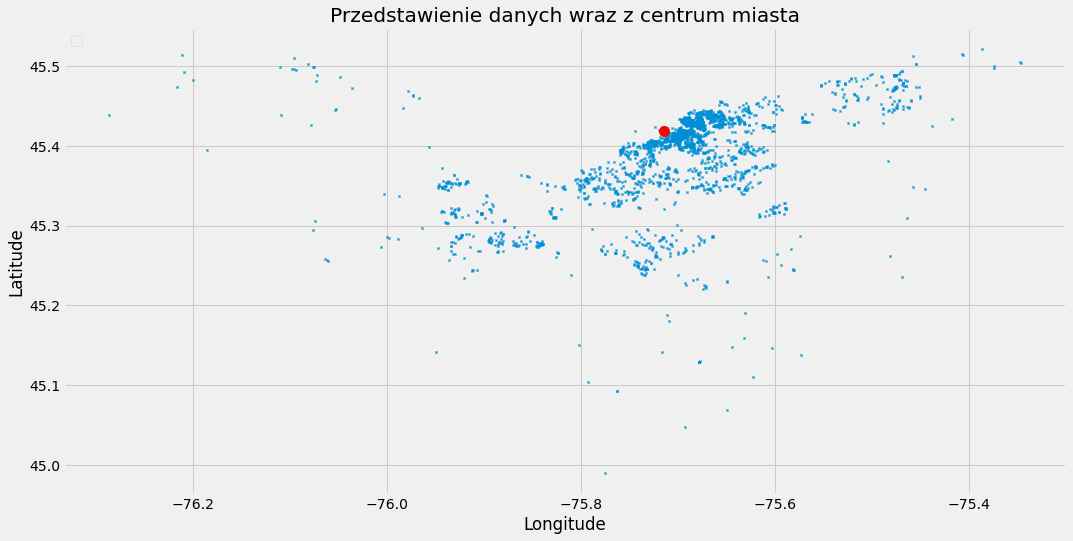

In [ ]:
center = [45.4190489,-75.7146491]

plt.figure(figsize=(16,8))
plt.plot(coords['longitude'], coords['latitude'], 'x', markersize=2)
plt.plot(center[1], center[0], 'ro', markersize=10)
plt.title('Przedstawienie danych wraz z centrum miasta')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# rozstep międzykwartylowy
Q1 = coords.quantile(0.25)
Q3 = coords.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
# IQR jak mocno można odstawać od środka danych
thresh = 1.8

In [ ]:
outliers = ((coords < (Q1 - thresh * IQR)) | (coords > (Q3 + thresh * IQR)))
coords_without_outliers = coords[~outliers.any(axis=1)]
coords_outliers = coords[outliers.any(axis=1)]

In [ ]:
print(coords.shape)
print(coords_without_outliers.shape)
print(coords_outliers.shape)

(2613, 2)
(2191, 2)
(422, 2)


In [ ]:
coords_without_outliers.head()

,longitude,latitude
0,-75.67900,45.40924
1,-75.74679,45.40159
2,-75.80314,45.35900
3,-75.69941,45.40248
4,-75.75496,45.38972


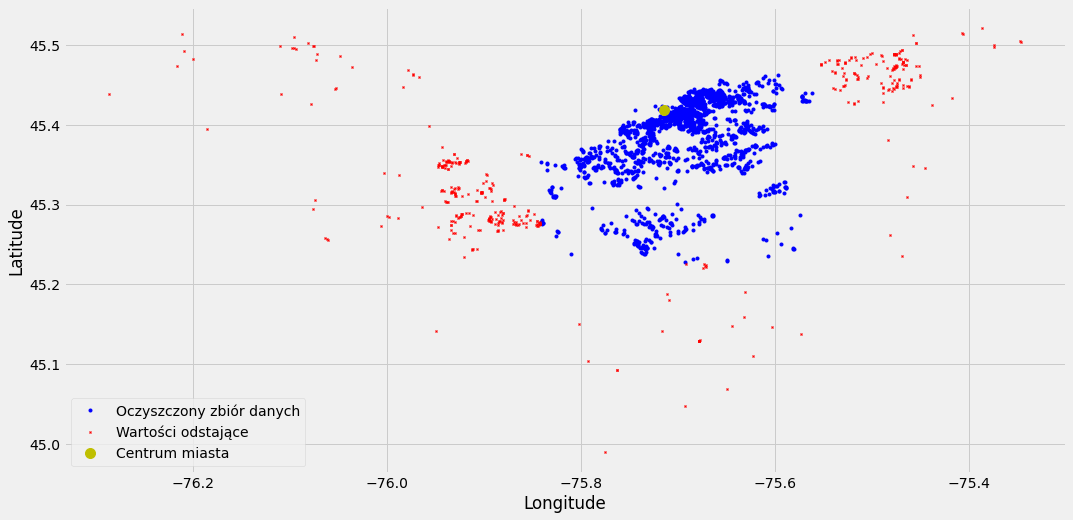

In [ ]:
center = [45.4190489,-75.7146491]

plt.figure(figsize=(16,8))
plt.plot(coords_without_outliers['longitude'], coords_without_outliers['latitude'], 'bo', markersize=3, label='Oczyszczony zbiór danych')
plt.plot(coords_outliers['longitude'], coords_outliers['latitude'], 'rx', markersize=2, label='Wartości odstające')
plt.plot(center[1], center[0], 'yo', markersize=10, label='Centrum miasta')
# plt.title('Przedstawienie danych')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower left')
plt.show()

Preprocessing do Analizy Sent

In [ ]:
df.loc[df['id'] == 45494801]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2528,45494801,https://www.airbnb.com/rooms/45494801,20201021220716,2020-10-24,PRIME Walk Location - Modern Studio Near Bywar...,This modern studio apartment in the heart of t...,The apartment is in the heart of the trendy By...,https://a0.muscache.com/pictures/c40ef387-3588...,57278041,https://www.airbnb.com/users/show/57278041,Carol,2016-02-03,"Toronto, Ontario, Canada",NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/acc68...,https://a0.muscache.com/im/pictures/user/acc68...,Yonge Eglinton,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Ottawa, Ontario, Canada",Rideau-Vanier,NaN,45.43207,-75.69191,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Iron"", ""Smoke alarm"", ""Shampoo"", ""Cooking ba...",$69.00,1,365,1,3,365,365,2.7,365.0,NaN,t,26,56,86,361,2020-10-24,4,4,4,2020-10-01,2020-10-21,100.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,t,10,10,0,0,4.0


In [ ]:
REVIEWS_URL = 'https://ids-storage-football-prediction.s3-eu-west-1.amazonaws.com/data_mmwd/reviews.csv'
CALENDAR_URL = 'https://ids-storage-football-prediction.s3-eu-west-1.amazonaws.com/data_mmwd/calendar.csv'
LISTINGS_URL = 'https://ids-storage-football-prediction.s3-eu-west-1.amazonaws.com/data_mmwd/listings.csv'

In [ ]:
listings = pd.read_csv(LISTINGS_URL)
reviews = pd.read_csv(REVIEWS_URL)

In [ ]:
reviews['comments'][5853]

'房子周围环境很好很安静,适合10人住宿'

In [ ]:
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,34220,https://www.airbnb.com/rooms/34220,20201021220716,2020-10-23,Room available,<b>The space</b><br />This room is part of a t...,NaN,https://a0.muscache.com/pictures/192935/3bf5a8...,147438,https://www.airbnb.com/users/show/147438,Mark,2010-06-18,CA,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,NaN,1,1,[],f,f,NaN,Capital,NaN,45.40924,-75.67900,Private room in apartment,Private room,2,NaN,1 bath,1.0,1.0,"[""Wifi"", ""Heating"", ""Free parking on premises""...",$202.00,7,31,7,7,31,31,7.0,31.0,NaN,t,1,1,1,1,2020-10-23,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
1,36642,https://www.airbnb.com/rooms/36642,20201021220716,2020-10-22,City Conveniences A Country Setting,<b>The space</b><br />Are you planning a vacat...,NaN,https://a0.muscache.com/pictures/7542487/52136...,157787,https://www.airbnb.com/users/show/157787,Donna,2010-07-04,"Ottawa, Ontario, Canada",I am originally from Nova Scotia but I have li...,NaN,NaN,100%,f,https://a0.muscache.com/im/users/157787/profil...,https://a0.muscache.com/im/users/157787/profil...,NaN,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,NaN,Kitchissippi,NaN,45.40159,-75.74679,Private room in house,Private room,2,NaN,2 baths,1.0,1.0,"[""Essentials"", ""Hot water"", ""Dryer"", ""Extra pi...",$65.00,3,14,3,3,14,14,3.0,14.0,NaN,t,29,59,89,364,2020-10-22,87,1,0,2010-07-11,2020-02-17,94.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,0,1,0,0.69
2,59258,https://www.airbnb.com/rooms/59258,20201021220716,2020-10-22,Lower level of my house to rent,"Lower 1/2 of bungalow, a separate entrance, 10...",NaN,https://a0.muscache.com/pictures/359337/5d90d6...,284351,https://www.airbnb.com/users/show/284351,Elena,2010-11-11,"Ottawa, Ontario, Canada",Canada rocks!,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/284351/profil...,https://a0.muscache.com/im/users/284351/profil...,NaN,1,1,"['email', 'phone', 'reviews', 'offline_governm...",t,t,NaN,Bay,NaN,45.35900,-75.80314,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Wifi"", ""Washer"", ""Dryer"", ""Heating"", ""Free p...",$200.00,3,730,3,3,730,730,3.0,730.0,NaN,t,0,0,0,0,2020-10-22,1,0,0,2011-07-04,2011-07-04,100.0,10.0,8.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.01


In [ ]:
listings.shape

(2613, 74)

In [ ]:
reviews.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,36642,63694,2010-07-11,126491,Robert,I gave Donna 4 stars only because she is new t...
1,36642,92464,2010-09-07,204008,Eduardo,Donna is a nice and pleasant person. We enjoye...
2,36642,100164,2010-09-19,164372,Asha,"Our trip was too short in Ottawa, we really wi..."


In [ ]:
reviews.shape

(99694, 6)

**Preprocessing reviews do analizy sentencji**

Należy zadbać o:
* brak pustych wierszy (null)
* usuwanie anulowanych przez 'hosta' wierszy
* należy usunąć recenzje w nierozpoznanym języku: możemy to osiągnąć za pomocą bibliotetki langedetect służącej do wykrywania języków.




In [ ]:
# liczba komentarzy pustych
reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         75
dtype: int64

In [ ]:
# anulowane
reviews['comments'].str.match('The host canceled this reservation').sum()

483

In [ ]:
reviews.dropna(subset =['comments'], how='any', axis=0, inplace=True)

index_canceled = reviews[ reviews['comments'].str.match('The host canceled this reservation')].index
reviews.drop(index_canceled, inplace=True)

index_dash = reviews[ reviews['comments'].str.match('-')].index
reviews.drop(index_dash, inplace=True)

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
reviews['comments'] = reviews['comments'].map(alphanumeric)


In [ ]:
reviews.reset_index(inplace=True, drop=True)

In [ ]:
reviews.shape

(99111, 6)

In [ ]:
# wyświetlenie błędów / błędnych komentarzy
num_errors = 0
err = []

for index, row in reviews.iterrows():
    try:
        language = detect(row['comments']) #(" ".join(row.split())) # row.strip())
    except:
        num_errors += 1
        err.append(index)
        print("This row throws an error:", row['comments'])

This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error:  
This row throws an error:  
This row throws an error: +
This row throws an error: .
This row throws an error: :)
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error: :)
This row throws an error: .
This row throws an error:  / 
This row throws an error:  / 
This row throws an error: .
This row throws an error: .
This row throws an error: ..
This row throws an error: !
This row throws an error: .
This row throws an error: ***
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error:  
This row throws an error: :)
This row throws an error:  / 
This row throws an error:  !
This row throws an error: .
This row throws an error: .
This ro

In [ ]:
print('Procent wpisów genrujących błędy - {:.2f}%'.format(num_errors/reviews['comments'].shape[0] * 100))

Procent wpisów genrujących błędy - 0.19%


In [ ]:
print(err) # indeksy wywołujące błędy

[2475, 6458, 6984, 8137, 9051, 10028, 10446, 10562, 14577, 14958, 16181, 16399, 16963, 17482, 18330, 18473, 18492, 18743, 19131, 19218, 19237, 19343, 20584, 20731, 20747, 23222, 23774, 23992, 24749, 25066, 26076, 26376, 26582, 26962, 27630, 28069, 28506, 28763, 30505, 30730, 30927, 31207, 31782, 31878, 32925, 32974, 33023, 33156, 33916, 34202, 38423, 39398, 39573, 39903, 40323, 40577, 40587, 40890, 40910, 41237, 41393, 43594, 43816, 43823, 44428, 45186, 45408, 45966, 46948, 47681, 48412, 48492, 50270, 51782, 52229, 53533, 53600, 54832, 55260, 55519, 55529, 55724, 55805, 56692, 57381, 58298, 59246, 60373, 61154, 61231, 61469, 61757, 63040, 63147, 63148, 63260, 63295, 63585, 63824, 64003, 64393, 65139, 65956, 66533, 66534, 66812, 66843, 68077, 68728, 68975, 69216, 69361, 69442, 69641, 70549, 70905, 71014, 71302, 71674, 71702, 71762, 71966, 72685, 72880, 74963, 75011, 75090, 76054, 76222, 76620, 77424, 78065, 78398, 79275, 79355, 79647, 79798, 79934, 80631, 81070, 81139, 81455, 82624, 828

In [ ]:
# wyrzucenie ze zbioru danych
reviews.drop(err, axis=0, inplace=True)

In [ ]:
reviews.reset_index(inplace=True, drop=True)

In [ ]:
reviews.shape

(98920, 6)

In [ ]:
# dodanie kolumny informującej o języku "language"
reviews['language'] = reviews['comments'].apply(detect)

In [ ]:
reviews.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,36642,63694,2010-07-11,126491,Robert,I gave Donna stars only because she is new t...,en
1,36642,92464,2010-09-07,204008,Eduardo,Donna is a nice and pleasant person. We enjoye...,en
2,36642,100164,2010-09-19,164372,Asha,"Our trip was too short in Ottawa, we really wi...",en


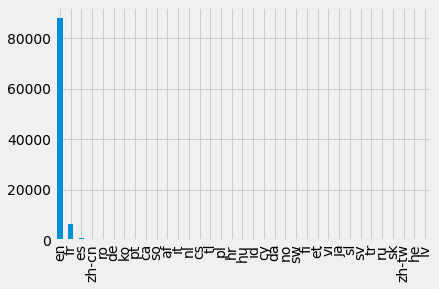

In [ ]:
# rozkład wykrytych języków
reviews['language'].value_counts().plot.bar();

In [ ]:
# kopia reviews z językami
reviews_en = reviews.copy(deep=True)

# odrzucenie null'i
index_nonen = reviews_en[~reviews_en['language'].str.match('en')].index

print('Procent reviews nie anglojęzycznych {:.2f}%'.format(len(index_nonen)/reviews_en.shape[0]))

Procent reviews nie anglojęzycznych 0.11%


In [ ]:
# drop
reviews_en.drop(index_nonen, inplace=True)

**Simplifying Sentiment Analysis using VADER in Python (on Social Media Text)**

VADER (Valence Aware Dictionary and sEntiment Reasoner) jest to narzędzie do analizy nastrojów, VADER jest dostosowany do analizy opinii wyrażonych w mediach. 

VADER okazał się całkiem skuteczny w przypadku tekstów w mediach społecznościowych, artykułów redakcyjnych NY Times, recenzji filmów i recenzji produktów. Dzieje się tak, ponieważ VADER nie tylko mówi o wynikach Pozytywności i Negatywności, ale także mówi nam, jak pozytywne lub negatywne są sentymenty.

Vader dodaje wartościowość do słów pisanych wielkimi literami, z interpunkcją (ex złożony wynik rośnie wraz z liczbą wykrzykników!), Z modiferes (np. Bardzo dobry vs dobry), emoji i obsługuje spójniki (... ale ... -> przesuwa w polaryzacji uczuć)

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# test działania

def sentiment_analyzer_scores(comment):
    score = analyzer.polarity_scores(comment)
    return(pd.DataFrame.from_dict(score, orient='index'))

sentiment_analyzer_scores(reviews_en['comments'][0])

,0
neg,0.000
neu,0.832
pos,0.168
compound,0.807


In [ ]:
# pożadamy jednego ogólnego wyniku "polarity", więc spójrzmy tylko na wynik „compound”
polarity_compound = lambda s: (analyzer.polarity_scores(s))['compound']

In [ ]:
reviews_en['polarity'] = reviews_en.comments.map(polarity_compound)

In [ ]:
# pierwsze 5 wyników
reviews_en[:5].style.bar(subset=['polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
0,36642,63694,2010-07-11,126491,Robert,"I gave Donna stars only because she is new to doing this....her house and garden are superb and her hospitality very welcoming. I will be returning soon. The location is quite central to the downtown area, shopping malls, and Quebec.",en,0.807000
1,36642,92464,2010-09-07,204008,Eduardo,Donna is a nice and pleasant person. We enjoyed our short stay at her home. She has a wonderful house with a fantastic garden in a safe and peaceful place. The room was comfortable and very clean. We are grateful to Donna for accommodate us.,en,0.985000
2,36642,100164,2010-09-19,164372,Asha,"Our trip was too short in Ottawa, we really wished we could have stayed longer because its a beautiful city. Donna was lovely, we didn't have much time to get to know her unfortunately.",en,0.743000
3,36642,262662,2011-05-14,414166,Emie,"Donna is a nice person. I had a short stay at her home.The room was comfortable,nice and very clean I wish I could have stayed longer.The location is quite central to the downtown area, shopping malls, and the train station. Emie",en,0.830400
4,36642,266613,2011-05-16,562356,Deepak,"Our stay at Donna's home was very pleasant. She was kind enough to let us in, late in the night and provided us with fresh coffee early in the morning. The backyard was very impressive and I was blown away to see the well maintained weed free lawn.",en,0.953700


In [ ]:
# pierwsze 5 wyników < 0
reviews_en[reviews_en['polarity']<0][:5].style.bar(subset=['polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
154,261065,558975202,2019-11-03,41645106,Craig,"Clean, modern apartment in the heart of Westboro. Well-equipped kitchen. Only caution is that the bed is comfortable, but very firm, and the pull-out couch in the office is not great for sleeping on. That said, it was a great base for us, and we're already planning our next visit.",en,-0.783400
196,365499,61815681,2016-02-08,4546957,Joyce,Anna was easy to coordinate with. My only concern was that there was no lock on the front door. I understand that Ottawa is a relatively safe place but still made me uncomfortable.,en,-0.273200
321,365499,614298248,2020-03-04,6155201,James,You won't find a better stay in the heart of the Glebe!,en,-0.401500
553,682632,59208844,2016-01-08,7860537,Keely,"Surprise goodies made my arrival special. The house was warm and accommodating in January, with a convenient location for foodies. The kitchen is equipped with quality equipment, which makes staying in for the odd meal a pleasure. If you have limited mobility, there are a few stairs at the entry, especially problematic as you use both hands to battle the electronic lock on the door that never works the first or second time, with luggage sliding down the stairs. A minor annoyance at - but a problem if you aren't fully able bodied.",en,-0.611900
605,793593,4710767,2013-05-21,2556963,Aleya,The location is great and it's only mints walk to downtown. There is a convenient store right at the corner of the street. All the museums are to mints drive. The house is not child friendly though. The flooring needs to be done because the (really) squeaky floor always woke my baby up. My toddler also fell from the stairs though we blocked the stairs with the chair. Lynda was Out of country and the manager was out of town so we sorted out our things on our own so no extra bed was available and no child safety gate was provided. There were rules pasted all over the house and we followed them strictly. Other then these things it's an ok place.,en,-0.092700


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



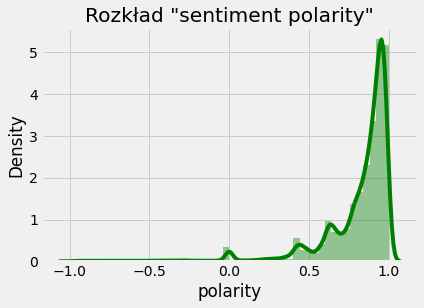

In [ ]:
# jak widzimy mamy rozkład bardzo bliski 1 (pozytywnych) -> zwykle opinie są pozytywne
sns.distplot(reviews_en['polarity'], norm_hist=True, color='g')
plt.title('Rozkład "sentiment polarity"');

In [ ]:
# przeniesienie rozszerzonego datasetu do pliku csv
reviews_en.to_csv('reviews_en_polarity.csv', index=False)

**Eksploracja danych oraz ich korelacja**

Wybranie z listings.csv wszystkich kolumn z indywidualnymi (dokładność, czystość, zameldowanie, komunikacja, lokalizacja i wartość) i ogólnymi (ocena) wynikami. Uwzględienie kolumny „id”, aby scalić ją z innymi ramkami danych i otoczeniem do późniejszej analizy.

In [ ]:
sel_listings = listings[['id', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                         'review_scores_cleanliness', 'review_scores_checkin', 
                         'review_scores_communication', 'review_scores_location', 'review_scores_value',
                         'neighbourhood_cleansed']]

sel_reviews = reviews_en[['listing_id', 'reviewer_id', 'comments', 'polarity']]

In [ ]:
sel_listings.head(3)

,id,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_cleansed
0,34220,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Capital
1,36642,87,94.0,10.0,10.0,10.0,10.0,10.0,9.0,Kitchissippi
2,59258,1,100.0,10.0,8.0,10.0,10.0,10.0,10.0,Bay


In [ ]:
sel_reviews.head(3)

,listing_id,reviewer_id,comments,polarity
0,36642,126491,I gave Donna stars only because she is new t...,0.807
1,36642,204008,Donna is a nice and pleasant person. We enjoye...,0.985
2,36642,164372,"Our trip was too short in Ottawa, we really wi...",0.743


In [ ]:
list_pol = pd.DataFrame(sel_reviews.groupby(['listing_id']).mean()['polarity'])

In [ ]:
full = pd.merge(sel_listings, list_pol, left_on='id', right_on='listing_id', how='left')

In [ ]:
full.head(3)

,id,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_cleansed,polarity
0,34220,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Capital,NaN
1,36642,87,94.0,10.0,10.0,10.0,10.0,10.0,9.0,Kitchissippi,0.874996
2,59258,1,100.0,10.0,8.0,10.0,10.0,10.0,10.0,Bay,0.972800


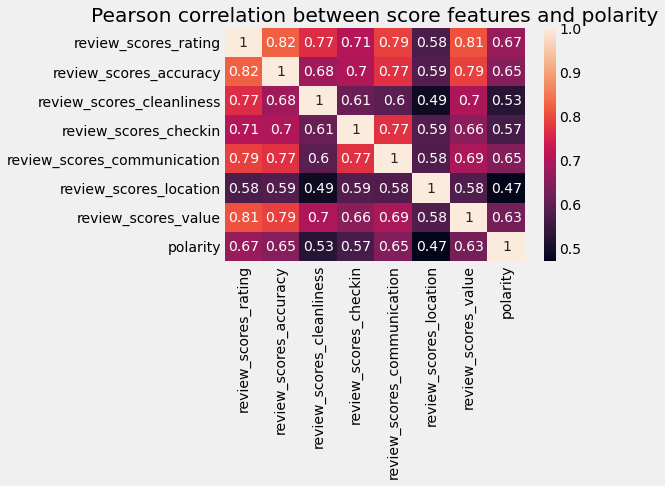

In [ ]:
review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                 'review_scores_value', 'polarity']

corr = full[review_scores].corr()

sns.heatmap(corr, annot=True)
plt.title('Korelacja Pearsona między cechami oceny a biegunowością');

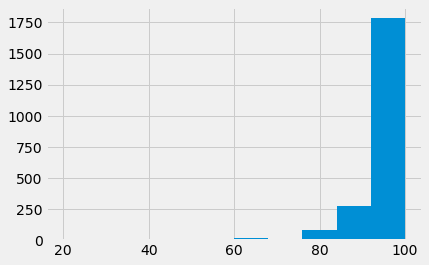

In [ ]:
full['review_scores_rating'].hist();

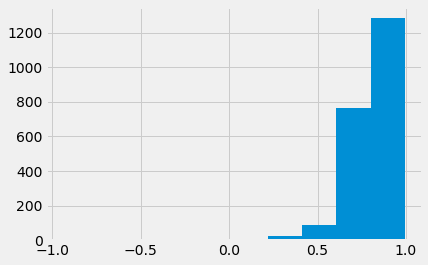

In [ ]:
full['polarity'].hist();

In [ ]:
listings_neighb = pd.DataFrame(full.groupby(['neighbourhood_cleansed']).mean())
listings_neighb.drop(['id'], axis=1, inplace=True)

In [ ]:
listings_neighb.head()

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,polarity
neighbourhood_cleansed,,,,,,,,,
Alta Vista,32.777778,95.511905,9.678571,9.619048,9.892857,9.833333,9.785714,9.642857,0.793706
Barrhaven,18.587302,95.018519,9.759259,9.574074,9.740741,9.722222,9.500000,9.537037,0.801598
Bay,24.760000,95.333333,9.807018,9.631579,9.842105,9.877193,9.736842,9.543860,0.801972
Beacon Hill-Cyrville,24.327586,93.041667,9.479167,9.125000,9.583333,9.625000,9.583333,9.270833,0.758306
Capital,49.758427,96.246667,9.840000,9.666667,9.913333,9.926667,9.893333,9.646667,0.841659


In [ ]:
listings_neighb.sort_values(['polarity'], ascending=False).head(3)

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,polarity
neighbourhood_cleansed,,,,,,,,,
Kitchissippi,38.382857,96.065789,9.794702,9.688742,9.874172,9.827815,9.900662,9.615894,0.850783
West Carleton-March,34.400000,96.250000,9.800000,9.725000,9.975000,9.850000,9.675000,9.600000,0.848120
Capital,49.758427,96.246667,9.840000,9.666667,9.913333,9.926667,9.893333,9.646667,0.841659


In [ ]:
listings_neighb.sort_values(['review_scores_location'], ascending=False).head(3)

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,polarity
neighbourhood_cleansed,,,,,,,,,
Kitchissippi,38.382857,96.065789,9.794702,9.688742,9.874172,9.827815,9.900662,9.615894,0.850783
Capital,49.758427,96.246667,9.840000,9.666667,9.913333,9.926667,9.893333,9.646667,0.841659
Somerset,59.261456,93.698052,9.594156,9.366883,9.792208,9.750000,9.798701,9.331169,0.785518
